In [10]:
import gensim.downloader
import pandas as pd
import numpy as np
import torch
import random
from nltk.tokenize import word_tokenize
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
import datasets
import matplotlib.pyplot as plt

# enabling inline plots in Jupyter
%matplotlib inline
datasets.logging.set_verbosity_error()

# Part 4: Word embeddings

In general modern word embeddings is the concept of using neural networks to convert words from a text corpus into vectors with a numerical value (Grimmer et al. 2022: 82). These embedded matrixes has a multitude of uses, as for example sentiment analysis, recommendation systems, and translation models. 

## Train your own word2vec vectors on the dataset. We recommend a vector size of 200, a window of 5, and three epochs of training. Make sure you tokenize and lowercase the words before feeding them into the model. 

To load and train a word2vec on United General Debate session from 2022 we start loading and cleaning the data.  

In [11]:
def load_and_process_data(filename):
    # Create an empty list to hold all sentences in the corpus
    corpus = []
    
    # Open the file and iterate over lines
    with open(filename, "r", encoding="utf-8") as f:
        for line in f:
            # Check that the line is not empty
            if line.strip() == '':
                continue
            # Tokenize and lowercase the string
            encoded_text = [word.lower() for word in word_tokenize(line)]
            # Add the list of tokens to the corpus
            corpus.append(encoded_text)
    
    return corpus

# Use the function to load and process the data
path = "dataset"
speeches = load_and_process_data(path+"/allspeeches_77_2022.txt")


When we use word embeddings four choices is essential, data source, context window size, dimension in the embedding and algorithm/architecture. As we have already been told the specifics of data (UN speeches), window size(5), feature lengths(200) and algorithm(word2vec) we will not go more in depth with these specifications. Word2ved is an algorithm to construct document embeddings from one's data, and was introduced by Le and Milov (2014) (Grimmer et al. 2022: 86; Hovy 2022b: 19). The primary thought behind a word2vec is that words which appear in the same context also have similar meaning. Thus a word2vec constructs vectors based on a text corpus in a multidimensional space, where words which are more or less close in the multidimensional space share more or less meaning. 

There are two architectures which can be implemented in the Word2Vec, either Skip-Gram(SG) or Continous Bag of Words (CBOW). In general SG outperforms CBOW, so we will use that architecture for this exercise (Ogundepo 2021). Another important step of Word2Vec is the choice of approach to update the weights in the neural network within Word2Vec, and here we choose the default of negative sampling. Without any optimization, the neural network needs to update the weights for all the words in the vocabulary during each training step, which can be computationally intensive for large vocabularies. Negative sampling's solution to this is to update the weights for a small, randomly chosen subset of 'negative' words (those not present in the context) along with the 'positive' word (the actual context word). The basic idea is that, instead of updating all the words, we update only a small number of negative samples and the positive word, saving the computing power.   

Besides the specifications already given us in this exercise we also set seed, select the skip-gram model, and choose to ignore low frequency words. 

https://medium.com/analytics-vidhya/understanding-word2vec-39fabe660705 Ogundepo, Odunayo  (2021): "Understanding Word2Vec",





In [12]:
def vec_function(seed):
    speech2vec = gensim.models.Word2Vec(
        speeches,         # the corpus object we've loaded
        vector_size=200,  # the dimensionality of the target vectors
        window=5,         # window ngram size
        min_count=4,      # ignoring low-frequency words
        epochs=3,         # how many training passes to have
        sg = 1,           # 1 for skip-gram model, 0 for cbow
        seed=seed)        # Set seed for 2vec, to be able to replicate the data¨
    return(speech2vec)
vec_seed13 = vec_function(seed=13)

(SKAL NOK BARE UD)
As embeddings are basically a matrix it is possible to apply an algorithm and to some degree visualise the relation in the text corpus between the different words. In the following we use the t-SNE algorithm, to get a overview of the general "closeness" in our word2vec between the different words. It is not apparent that any kind of cluster exist within our model. 

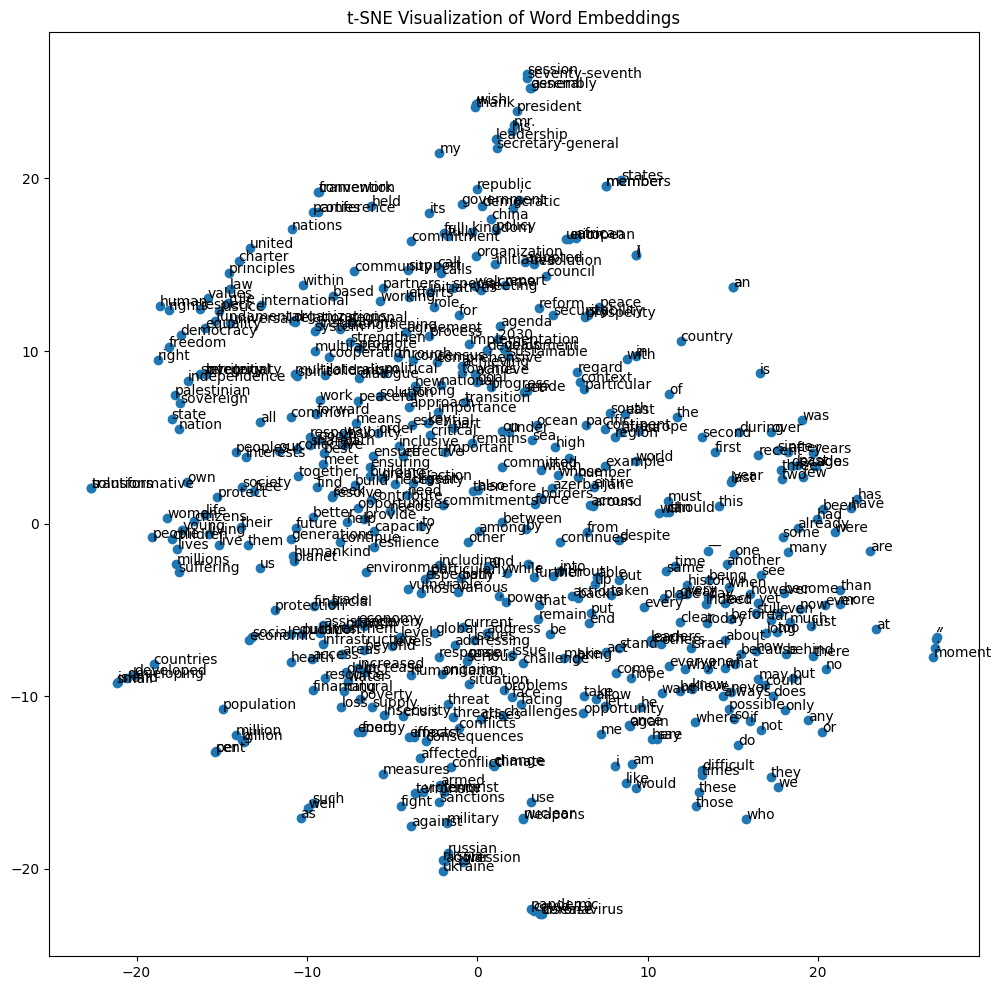

In [109]:
# T-SNE of Word2Vec (SKAL NOK UD)

embedding =  vec_seed13

# Get first 200 words for visualization
words = list(embedding.wv.key_to_index.keys())[:500]

# Get the corresponding vectors for the words
word_vectors = embedding.wv[words]

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
reduced_vectors = tsne.fit_transform(word_vectors)

# Extract x and y coordinates
x_coords = reduced_vectors[:, 0]
y_coords = reduced_vectors[:, 1]

# Plot the embeddings
plt.figure(figsize=(12, 12))
plt.scatter(x_coords, y_coords)

# Add labels for each point
for i, word in enumerate(words):
    plt.annotate(word, (x_coords[i], y_coords[i]))

plt.title('t-SNE Visualization of Word Embeddings')
plt.show()


## Print out the ten words that are most similar to: “climate”, “pandemic”, “terrorism” and “future” (or choose your own four words of interest). Briefly discuss anything you find noteworthy about the associations that the model has picked up.

In [110]:
# Looking for the ten words which are closest to climate, pandemic, terrorism, future
word_of_interest = ["gender", "elizabeth", "russia", "ukraine"] 

# Constructing a function for finding the top ten most similar words
def find_top_words(word_of_interest, model):
    df = pd.DataFrame() 
    for word in word_of_interest:
        similar_words = list(map(lambda x: x[0], model.wv.most_similar(word, 10))) # Using the most_similar function to find the 10 words
        df[word] = similar_words
    return(df) # Returning a dataframe

top_words_seed13 = find_top_words(word_of_interest = word_of_interest, model= vec_seed13)
top_words_seed13

,gender,elizabeth,russia,ukraine
0,equality,king,ukraine,russia
1,empowerment,majesty,russian,russian
2,participation,queen,aggression,military
3,technical,abdullah,military,aggression
4,protection,congratulating,illegal,forces
5,public,charles,invasion,armed
6,promotion,abdulla,forces,conflict
7,women,excellency,unprovoked,war
8,capital,csaba,federation,illegal
9,youth,maldives,occupation,crimes


As the word2vec creates a geometric space for words, we are able to interpret the words based on their spatial relationship in the word2vec model. An essential weakness within the word2vec models is homographs such as *bat*, *tear*, or *lead* which all have two distinct different meanings, which the model would not be able to distinguish between the words. This results in a loss of specificity. In newer models such as BERT, they have implemented contextual embeddings, which are better at capturing these nuances in the language.   

In the above function we have chosen the four words based on either topics of interest or based on key events 2022, `gender`, `elizabeth`, `ukraine`, and `russia`:

Starting with `gender`, we see that *empowerment* and *protection* are the two most similar or closest words to gender. On a more broad note is it interesting that men is not a similar word to gender but `women` is. A Beauvoirian notion regarding this would be that men are considered the 'default' gender, and women is the 'other', the gender which is talked about when discussing gender. Another take could also be that the speeches in the UN regarding gender to a higher degree discuss the necessity of empowerment and protection of women because they need it more than men. 
The second word we look up is `elisabeth`, this is specifically with regards to queen Elisabeths death in 2022. It makes sense that *king*, *charles*, and *iii* all are close to this in the semantic space since they probably refer to her son King Charles III. The words *abdulla*/*abdullah* and *shahid* probably refers to Abdullah Shahid, a key politician within the UN. The last two words which we included are `russia` and `ukraine` because 2022 was when Russia attacked Ukraine. Both countries have each other as the most similar, and in general have multiple words in common. Furthermore are all of their words in some way or another related to the war. It is interesting that Ukraine has the word *sanction* which probably also relates to their call for sanctions towards Russia, and *armed* which could be related to their call for support of arms for defending themselves. 

On a final note, the above represent our considerations regarding the analysis of the nearest neighbors of the four chosen words and their corresponding 10 words. When presenting these it is important to keep in mind that the Word2Vec can't tell us anything regarding the word interpretability outside the words spatial relationship. This is a humane process which needs to be supported by logical arguments. (NOK BARE UD)

## Suppose that we would like to use these word embeddings as input in a supervised model, detecting whether the speech comes from a country in the global North or the global South. Briefly discuss the upside(s) and downside(s) of training your word embeddings locally, on the speeches themselves, versus using pre-trained embeddings.

When deciding whether to use and train our own word embeddings locally or to use pre-trained embeddings an important consideration is how niché our own text corpora is compared with more general corpora which pre-trained models normally are trained on, such as Wikipedia or english dictionaries (Rodriguez & Spirling 2022: 6). The danger using a pre-trained model would be that the more niche words of the UN 2022 speeches would be placed in spatial relation with words in the more general corpora which the pre-trained model uses. The UN speech’s words could then lose their more distinct specific meaning within the UN. Another danger would be that the words in our speech corpora are not within the pre-trained model's vocabulary, and therefore would need to be handled as an out-of-vocabulary word, which represents a problem (Grimmer et al. 2022: 84f). On the other side does a locally trained model also present some problems, and the most essential consideration for us is that we are lacking in data to make a good local embedding model which is able to compete with a pre-trained embedding model. As we only have 77 speeches in the UN in 2022 for our word2vec to be trained on.  

In general Rodriguez & Spirling find that the pre-trained embeddings do well even compared with human constructed nearest neighbor, and the pre-trained embeddings often do even better than the locally trained models (Rodriguez & Spirling 2022: 15-16). This would probably also be the case for this model. If one would seek the flexibility (because you to a higher degree can adjust your own parameters) and the context-specificity of a local model, a solution could be to include speeches before 2022, or maybe include english speeches from other multi country organizations (European Union, African Union), but both of these solutions would also contaminate the text corpus outside of the UN 2022 sphere.

## (optional) Train the model again (set a different random seed if you used a seed in step 1), print the most similar words again, and compare your two results. Are the word embeddings stable?


In [111]:
vec_seed12 = vec_function(seed=12)
top_words_seed12 = find_top_words(word_of_interest= word_of_interest, model=vec_seed12)


In [113]:
seed12_data = top_words_seed12["gender"]
seed13_data = top_words_seed13["gender"]

print(f"Gender Seed 12:\n{'-'*20}")
for key, value in seed12_data.items():
    print(f"{key}: {value}")

print(f"\nGender Seed 13:\n{'-'*20}")
for key, value in seed13_data.items():
    print(f"{key}: {value}")

Gender Seed 12:
--------------------
0: empowerment
1: girls
2: protection
3: women
4: youth
5: technical
6: employment
7: equality
8: assistance
9: capital

Gender Seed 13:
--------------------
0: equality
1: empowerment
2: participation
3: technical
4: protection
5: public
6: promotion
7: women
8: capital
9: youth


In the above code we run a new Word2Vec on a new seed, and print and compare for example the gender variable within the two lists generated from using either seed 12 or 13 we observe in general that the model is exactly stable. To some degree the Word2vec will often have room for some instability, as some randomizing elements are active in the model as for example the aforementioned negative sampling. But it seems the model is quite unstable and this is probably because of the small size of our text corpus. 

## (optional) Conduct an informal validation of the embeddings from your first run, by checking their ability to find the “odd one out” in three different series of four–five terms related to international relations and current events (e.g. “covid”, “pandemic”, “disease”, “vaccine”, “environment”). Briefly discuss how you might validate the embeddings more systematically, if you had more time and resources. 

In [106]:
list_of_lists_of_words = {
    "war": ["bombs", "guns", "ammo", "tanks" "cake"],
    "climate": ["floods", "drought", "heatwave", "hallo"],
    "nations": ["china", "america", "india", "hammer"],
    "covid 19": ["covid", "pandemic", "disease", "vaccine", "environment"]
}
for key, value in list_of_lists_of_words.items():
    print(f"For '{key}' the odd one out is: {vec_seed13.wv.doesnt_match(value)}")

For 'war' the odd one out is: bombs
For 'climate' the odd one out is: drought
For 'nations' the odd one out is: america
For 'covid 19' the odd one out is: environment


Looking into the how well the model recognizes the "odd one out" our model is failing quite a bit. It only succeeds in finding the ´environment´ in the covid 19 list, and find the wrong one in all the other lists.  

When considering the validation of embeddings models one can think of extrinsic and intrinsic evaluation for checking the validation of the embeddings. Extrinsic evaluation  is how well the embedding would do if given to a model and for this one can include, noun phrase chunking, part of speech tagging, and named entity recognition. For intrinsic evaluation the focus is on how successful the model is presenting word similarity (Grimmer et al. 2022: 87). For validating this we can look into analogy solvings and clustering tasks like the one asked from the exercise above to see how well the model succeeds in comparing different words. 

If one had the time and ressources the method presented by Rodriguez & Spirling (2021), who construct a nearest neighbor list for ten words using labellers and another nearest neighbor list using an embedding model (Rodriguez & Spirling 2021: 11). They then test the embedding model by other people to choose between which of the two nearest neighbor lists they think have the best nearest neighbor results, thus they can compare their embedding model to that of normal humans. 


#### SKRALD


In [ ]:
# Constructing the DataLoader for preparing data for the word2vec

class MyDataLoader(object):

    # when we initialize this dataloader, it will take a filename as an argument
    def __init__(self, filename):
        self.corpus = filename

    # we will need to define what counts as a "chunk" in this file, so when the
    # Dataloader is loading (iterating over) the file and feeding it to the embedding
    # model, it knows what to treat as one unit. Here, we (arbitrarily) say that one
    # line in the file (corresponding to a paragraph) is one chunk.
    def __iter__(self):
        for line in open(self.corpus, "r", encoding="utf-8"): # lines are split by "\n"
            # check that the line is not empty (if it is, do nothing):
            if line == None:
                continue
            # tokenize and lowercase the string before yielding it
            encoded_text = []
            tokens = word_tokenize(line)
            for t in tokens:
                index = t.lower()
                encoded_text.append(index)
            # the output must be a list of tokens in the line
            yield encoded_text

# Loading and cleaning the data
path = "dataset"
speeches_test = MyDataLoader(path+"/allspeeches_77_2022.txt")